In [15]:
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_groq import ChatGroq
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.messages.utils import trim_messages, count_tokens_approximately
from langchain.messages import RemoveMessage
from dotenv import load_dotenv

In [16]:
load_dotenv()

True

In [17]:
llm = ChatGroq(model="llama-3.3-70b-versatile")

In [18]:
def chat(state: MessagesState):
    
    response = llm.invoke(state["messages"])
    return {"messages": [response]}

In [19]:
def delete_old_messages(state: MessagesState):
    
    msgs = state["messages"]

    # if more than 10 messages, delete the earliest 6
    if len(msgs) > 10:
        
        to_remove = msgs[:6]
        return {"messages": [RemoveMessage(id=m.id) for m in to_remove]}

    return {}

In [20]:
builder = StateGraph(MessagesState)

builder.add_node("chat", chat)
builder.add_node("cleanup", delete_old_messages)

In [21]:
builder.add_edge(START, "chat")
builder.add_edge("chat", "cleanup")   # run deletion after each response
builder.add_edge("cleanup", END)

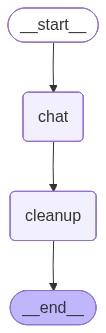

In [22]:
checkpointer=InMemorySaver()

graph = builder.compile(checkpointer=checkpointer)
graph

In [23]:
config = {"configurable": {"thread_id": "t1"}}

In [24]:
# Run multiple turns
graph.invoke({"messages": [{"role": "user", "content": "Hi, I'm Hamza"}]}, config)
graph.invoke({"messages": [{"role": "user", "content": "Tell me about LangGraph"}]}, config)
graph.invoke({"messages": [{"role": "user", "content": "Now explain checkpointers"}]}, config)
graph.invoke({"messages": [{"role": "user", "content": "What is Langchain"}]}, config)
graph.invoke({"messages": [{"role": "user", "content": "What is Quantum Mechanics"}]}, config)
graph.invoke({"messages": [{"role": "user", "content": "What is Gen AI"}]}, config)
graph.invoke({"messages": [{"role": "user", "content": "What is my name"}]}, config)

{'messages': [HumanMessage(content='What is Langchain', additional_kwargs={}, response_metadata={}, id='99b7f7a3-d893-4b86-9bbf-ce77a8a647bd'),
  AIMessage(content='LangChain is an open-source framework for building applications on top of large language models (LLMs) like LangGraph. It provides a set of tools and APIs that enable developers to create custom applications that leverage the capabilities of LLMs.\n\n**Key Features of LangChain**\n\n1. **Modular Architecture**: LangChain has a modular architecture that allows developers to build custom applications by combining different components, such as language models, databases, and APIs.\n2. **LLM Integration**: LangChain provides pre-built integrations with popular LLMs like LangGraph, allowing developers to easily access and utilize the capabilities of these models.\n3. **Application Templates**: LangChain provides pre-built application templates that enable developers to quickly create common applications, such as chatbots, langua

In [25]:
snap = graph.get_state(config)
print("Stored messages after cleanup:", len(snap.values["messages"]))

Stored messages after cleanup: 8
